In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

# Start time
start_time = time.time()

# Load all results xlsx files
df_tfidf = pd.read_excel('results_combined_tdidf.xlsx')
df_wordembedding = pd.read_excel('results_combined_wordembedding.xlsx')
df_bow = pd.read_excel('results_combined_bow.xlsx')
df_rnn = pd.read_excel('results_combined_all_rnn.xlsx')
df_rnn
# Load the additional CSV file containing the Transformer Bert model results
df_bert = pd.read_csv('combined_evaluation.csv')

# Extract the necessary values from the CSV file
bert_models = df_bert['Model'].unique()
bert_summary = {
    'Model': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Ecological': [],
    'Computational Effort': []
}

In [5]:
for model in bert_models:
    model_data = df_bert[df_bert['Model'] == model]
    accuracy = model_data['accuracy'].values[0]
    f1_score = model_data['weighted avg - f1-score'].values[0]
    roc_auc = model_data['macro avg - recall'].values[0]  # Assuming ROC AUC is similar to macro avg recall
    bert_summary['Model'].append('Transformer')
    bert_summary['Accuracy'].append(accuracy)
    bert_summary['ROC AUC'].append(roc_auc)
    bert_summary['F1 Score'].append(f1_score)
    bert_summary['Ecological'].append(0.35)
    bert_summary['Computational Effort'].append(3000)  # Computational Effort for Transformer models

df_bert_summary = pd.DataFrame(bert_summary)


# Add a column to indicate the technique
df_tfidf['Technique'] = 'Classical ML Models'
df_wordembedding['Technique'] = 'Classical ML Models'
df_bow['Technique'] = 'Classical ML Models'
df_bert_summary['Technique'] = 'Transformer'
df_rnn['Technique'] = 'RNN'

# Add the Ecological column to the standard models
df_tfidf['Ecological'] = 0.7
df_wordembedding['Ecological'] = 0.5
df_bow['Ecological'] = 0.8
df_rnn['Ecological'] = 0.6

# Add the Computational Effort column to the standard models
df_tfidf['Computational Effort'] = 412.02
df_wordembedding['Computational Effort'] = 1188.30
df_bow['Computational Effort'] = 1107.85
df_rnn['Computational Effort'] = 316.22

# Add the Potential column based on model type
df_tfidf['Potential'] = 0.3
df_wordembedding['Potential'] = 0.3
df_bow['Potential'] = 0.3
df_rnn['Potential'] = 0.6
df_bert_summary['Potential'] = 1.0


In [6]:

# Combine the results into a single DataFrame
results_combined = pd.concat([df_tfidf, df_wordembedding, df_bow, df_rnn, df_bert_summary], ignore_index=True)

# Generalize the models into categories
results_combined['Model'] = results_combined['Technique']

In [7]:
# Add a dummy model with all metrics set to 0
dummy_model = pd.DataFrame({
    'Model': ['Dummy'],
    'Accuracy': [0],
    'ROC AUC': [0],
    'F1 Score': [0],
    'Ecological': [0],
    'Computational Effort': [4000],
    'Performance': [0],
    'Simplicity': [0],
    'Potential': [0]
})

In [8]:
# Ensure only numeric columns are included when calculating the mean
numeric_columns = ['Accuracy', 'ROC AUC', 'F1 Score', 'Ecological', 'Computational Effort', 'Potential']

# Group by the generalized model categories and calculate the mean
summary_data = results_combined.groupby('Model')[numeric_columns].mean().reset_index()

# Calculate the Performance column as the average of Accuracy, F1 Score, and ROC AUC
summary_data['Performance'] = summary_data[['Accuracy', 'ROC AUC', 'F1 Score']].mean(axis=1)

# Add the Simplicity column
summary_data['Simplicity'] = summary_data['Model'].apply(lambda x: 0.7 if x == 'Classical ML Models' else (0.4 if 'RNN' in x else 0.2))

# Add the dummy model to the summary data
summary_data = pd.concat([summary_data, dummy_model], ignore_index=True)

# Normalize the Computational Effort column to a common scale (0 to 1) and invert it
summary_data['Computational Effort'] = 1 - (summary_data['Computational Effort'] - summary_data['Computational Effort'].min()) / (summary_data['Computational Effort'].max() - summary_data['Computational Effort'].min())


In [9]:
# Display the DataFrame
print(summary_data)


                 Model  Accuracy   ROC AUC  F1 Score  Ecological  \
0  Classical ML Models  0.694158  0.583275  0.646261    0.666667   
1                  RNN  0.687603  0.653829  0.639031    0.600000   
2          Transformer  0.741714  0.648183  0.722093    0.350000   
3                Dummy  0.000000  0.000000  0.000000    0.000000   

   Computational Effort  Potential  Performance  Simplicity  
0              0.840788        0.3     0.641231         0.7  
1              1.000000        0.6     0.660154         0.4  
2              0.271460        1.0     0.703997         0.2  
3              0.000000        0.0     0.000000         0.0  


In [10]:
# Define the radar chart function
def create_radar_chart(df, metrics, title):
    labels = metrics
    num_vars = len(labels)

    # Calculate angles for the metrics
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Ensure the chart closes

    # Create the plot with a wider aspect ratio
    fig, ax = plt.subplots(figsize=(24, 8), subplot_kw=dict(polar=True))  # Adjusted figsize to make it wider
    color_map = cm.get_cmap('YlGnBu_r', len(df))

    for i, row in df[df['Model'] != 'Dummy'].iterrows():  # Exclude the dummy model
        values = row[metrics].tolist()
        values += values[:1]  # Close the chart
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Model'], color=color_map(i))
        ax.fill(angles, values, alpha=0.5, color=color_map(i))  # Adjust alpha for filled area

    # Style the chart
    ax.set_ylim(0, 1)  # Set the limit for the radial axis
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])  # Set the ticks for the radial axis
    ax.set_yticklabels([])  # Remove radial ticks
    ax.set_xticks(angles[:-1])  # Set angles for metric labels
    ax.set_xticklabels(labels, fontsize=14, fontweight='bold')

    # Title and legend positioning
    plt.title(title, size=20, color='black', y=1.1, fontweight='bold', ha='center')  # Center title
    plt.legend(title="Model Categories", loc='center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=1, handletextpad=1.5)  # Adjust legend labels to be next to each other

    plt.show()


C:\Users\TColt\AppData\Local\Temp\ipykernel_11152\1263858051.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('YlGnBu_r', len(df))


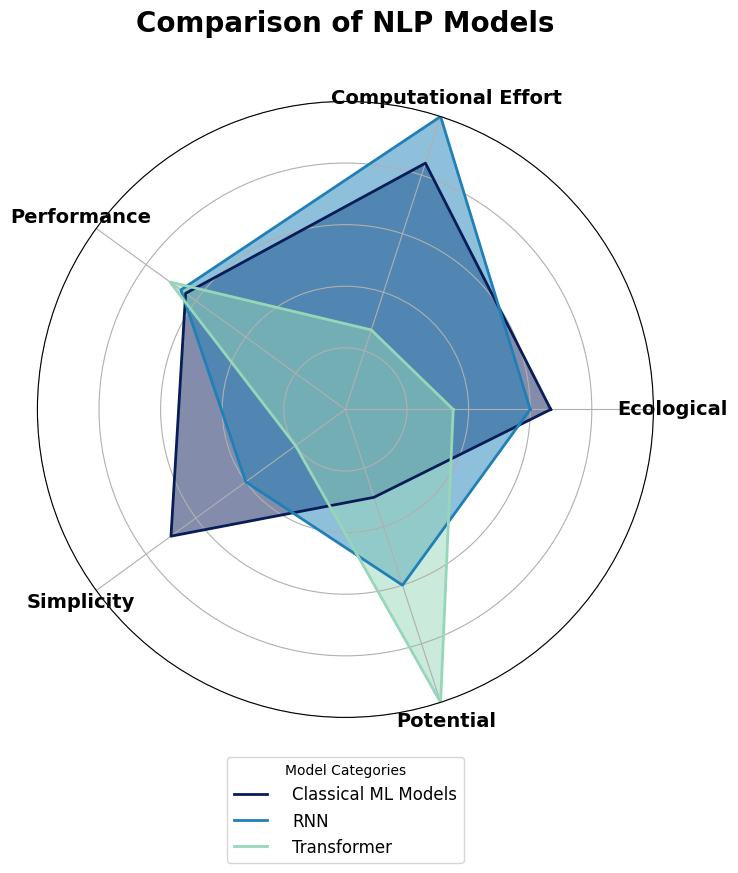

In [11]:
# Define the metrics to plot
metrics = ['Ecological', 'Computational Effort', 'Performance', 'Simplicity', 'Potential']

# Create the radar chart
create_radar_chart(summary_data, metrics, 'Comparison of NLP Models')

In [ ]:
# End time
end_time = time.time()
total_time = end_time - start_time

print(f"Total runtime of the notebook: {total_time:.2f} seconds")